In [1]:
## Cell type specific model 
### total counts 
import pandas as pd
import numpy as np
import math
from itertools import combinations
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')
import subprocess
from adjustText import adjust_text
import scanpy as sc
sc.settings.verbosiforty = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import anndata as ad
import scipy.sparse as sp

import muon as mu
from muon import prot as pt

scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.6 pynndescent==0.5.13


## Work flow 
1. cellrangker 

In [2]:
output, data = [],[]
for i in os.listdir('./white_list'):
    if 'check' not in i:
        data.append(i.replace('.tsv',''))

data = pd.DataFrame({'sample': data})
data['name'] = [i for i in data['sample']]
data['project'] = [i.split('_IGO')[1].split('_')[1] for i in data['name']]
data['ID'] = [i.split('_IGO')[0].split('_')[1] for i in data['name']]
data = data.sort_values(by = ['project'])

## Read individual folders 

In [19]:
input_data = data[data['project'] == '14423'].sort_values(by = ['ID'])
meta = pd.read_csv('project_14423_meta.csv',sep ='\t',header = None)
meta.columns = ['patient','timepoint','time','date','sample_id','barcode','date_processed','seq_sample','ID','trial']
meta['ID'] = meta['ID'].astype(str)

base = '/data1/greenbab/users/yaon/Ravetch_scRNA/Project_14423_D/DIANA_0595'
c_list = []
for k in os.listdir(base):
    if 'v1' not in k:
        print(f'{k}_FB')
        c_list.append(f'{k}_FB')

cdf = pd.DataFrame({'cite':c_list})
cdf['ID'] =[ i.split('_')[1] for i in cdf['cite']]
cdf['name'] =[ i.replace('_FB','') for i in cdf['cite']]
cdf['dir'] = [i.replace('_D','').replace('_FB','') for i in cdf['name']]

input_cdf = cdf[cdf['ID'].isin(meta['ID'])]

input_cdf

Sample_1008_FB_IGO_14423_D_8_FB
Sample_1004_FB_IGO_14423_D_4_FB
Sample_1002_FB_IGO_14423_D_2_FB
Sample_1005_FB_IGO_14423_D_5_FB
Sample_1001_FB_IGO_14423_D_1_FB
Sample_1007_FB_IGO_14423_D_7_FB
Sample_1003_FB_IGO_14423_D_3_FB
Sample_1006_FB_IGO_14423_D_6_FB


,cite,ID,name,dir
0,Sample_1008_FB_IGO_14423_D_8_FB,1008,Sample_1008_IGO_14423_D_8,Sample_1008_IGO_14423_8
1,Sample_1004_FB_IGO_14423_D_4_FB,1004,Sample_1004_IGO_14423_D_4,Sample_1004_IGO_14423_4
2,Sample_1002_FB_IGO_14423_D_2_FB,1002,Sample_1002_IGO_14423_D_2,Sample_1002_IGO_14423_2
3,Sample_1005_FB_IGO_14423_D_5_FB,1005,Sample_1005_IGO_14423_D_5,Sample_1005_IGO_14423_5
4,Sample_1001_FB_IGO_14423_D_1_FB,1001,Sample_1001_IGO_14423_D_1,Sample_1001_IGO_14423_1
5,Sample_1007_FB_IGO_14423_D_7_FB,1007,Sample_1007_IGO_14423_D_7,Sample_1007_IGO_14423_7
6,Sample_1003_FB_IGO_14423_D_3_FB,1003,Sample_1003_IGO_14423_D_3,Sample_1003_IGO_14423_3
7,Sample_1006_FB_IGO_14423_D_6_FB,1006,Sample_1006_IGO_14423_D_6,Sample_1006_IGO_14423_6


In [21]:
p14423_protein_list, p14423_rna_list =[] ,[] 

for directory, ID in zip(input_cdf['cite'], input_cdf['ID']):

    ID = str(ID)

    if ID != '1007':
    
        print(ID)
        
        # f = pd.read_csv(f'./{directory}/outs/filtered_feature_bc_matrix/features.tsv.gz',index_col = 0,header = None,sep = '\t')
        # b = pd.read_csv(f'./{directory}/outs/filtered_feature_bc_matrix/barcodes.tsv.gz', index_col =0 ,header =None)
        # b.index.names =['index']
        # f.index.names =['index']
        # adt_data = ad.read_mtx(os.path.join(directory,'./outs/filtered_feature_bc_matrix/matrix.mtx.gz'))
        # adt_data = adt_data.T
        # adt_data.obs = b
        # adt_data.var = f
        # adt_data.var.columns = ['gene','data_type']
        
        sample_dict, time_dict = {},{}
        
        for a,b in zip(meta[meta['ID']== str(ID)]['barcode'], 
                       meta[meta['ID']== str(ID)]['patient'].astype(int)):
            sample_dict[a] = str(b)
        
        for a,b in zip(meta[meta['ID']== str(ID)]['barcode'], 
                       meta[meta['ID']== str(ID)]['timepoint']):
            time_dict[a] = b
        
        meta_dir = directory.replace('_FB','').replace('_D','')
        
        path = f'/data1/greenbab/users/yaon/Ravetch_scRNA/{meta_dir}/outs/'
        adata = sc.read_10x_h5(f'{path}/filtered_feature_bc_matrix.h5')
        # mitochondrial genes, "MT-" for human, "Mt-" for mouse
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        # ribosomal genes
        adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
        # hemoglobin genes
        adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
        sc.pp.calculate_qc_metrics(  adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
        
        adata.obs['log10_total'] = np.log10(adata.obs['total_counts'])
        adata.obs['log10_n_genes_by_counts'] = np.log10(adata.obs['n_genes_by_counts'])
        
        demux = pd.read_csv(f'{meta_dir}_meta_v2.csv',sep = '\t')
        adata.obs = pd.concat([adata.obs, demux[['hash.ID']]], axis= 1) 
        
        adata_clean = adata[(~adata.obs['hash.ID'].isna()) & (~adata.obs['hash.ID'].isin(['Negative', 'Doublet','unmapped'])) ]
        adata_clean.obs['barcode'] = [int(i.split('-')[0].replace('HTO','')) for i in adata_clean.obs['hash.ID']]
        adata_clean.obs['ident'] = adata_clean.obs.index
        adata_clean.obs['10X_ID'] = ID
        adata_clean.obs['patient'] =adata_clean.obs['barcode'].map(sample_dict)
        adata_clean.obs['timepoint'] =adata_clean.obs['barcode'].map(time_dict)
        
        adata_clean = adata_clean[(~adata_clean.obs['patient'].isna())]
        ### filter by MT 
        adata_clean = adata_clean[adata_clean.obs['pct_counts_mt']<=10]
        
        # ######################## cell ranger output ################
        # adt_match = adt_data[adt_data.obs.index.isin(adata_clean.obs.index),:]
        # obs = pd.concat([ adt_match.obs, adata_clean.obs[['patient','timepoint','10X_ID']]],axis= 1)
        # adt_match.obs = adata_clean.obs.T[adt_match.obs.index].T[['patient','timepoint','10X_ID']]
        # adt_match.obs['cohort'] = 14450
        # adt_match_clean = adt_match[:,adt_match.var[adt_match.var['data_type'] == 'Antibody Capture'].index]
        
        # ### match RNA and protein 
        # adata_clean_match = adata_clean[adt_match_clean.obs.index,:]
        
        ################ CITE map ################
        rna_barcode = [i.replace('-1','') for i in adata_clean.obs.index]
        k = '_'.join(directory.split('_')[:-1])
        path = f'{k}_CITE_v2'
        f = pd.read_csv(f'./{path}/umi_count/features.tsv.gz',header = None, index_col =0 )
        b = pd.read_csv(f'./{path}/umi_count/barcodes.tsv.gz', index_col =0 ,header =None)
        b.index.names =['index']
        f.index.names =['index']
        adt_data = ad.read_mtx(os.path.join(path,'umi_count/matrix.mtx.gz')).T
        adt_data.obs = b
        adt_data.var = f
        
        adt_data = adt_data[rna_barcode,:]
        adt_data.obs = adata_clean.obs[['patient','timepoint','ident']]
        
        mdata = mu.MuData({"rna": adata_clean, "prot": adt_data,})
        mdata['rna'].var['gene'] = mdata['rna'].var.index
        mdata['rna'].var.index = mdata['rna'].var['gene_ids']
        mdata["prot"].var.index = [i.split('-')[0] for i in mdata["prot"].var.index]

        mdata['rna'].obs['cohort'] = 14423 
        mdata['prot'].obs['cohort'] = 14423 
    
        mdata['rna'].obs.index = mdata['rna'].obs['patient'].astype(str)+"|"+mdata['rna'].obs['timepoint'].astype(str)+"|"+mdata['rna'].obs['ident'].astype(str)
        mdata['prot'].obs.index = mdata['prot'].obs['patient'].astype(str)+"|"+mdata['prot'].obs['timepoint'].astype(str)+"|"+mdata['prot'].obs['ident'].astype(str)
        
            
        ##### list 
        p14423_rna_list.append(mdata['rna'])
        p14423_protein_list.append(mdata['prot'])

1008
1004
1002
1005
1001
1003
1006


In [23]:
input_data = data[data['project'] == '14450'].sort_values(by = ['ID'])
meta = pd.read_csv('project_14450_meta.csv',sep ='\t',header = None)
meta.columns = ['patient','timepoint','time','date','sample_id','barcode','date_processed','seq_sample','ID','trial']
meta['ID'] = meta['ID'].astype(str)

base =  '/data1/greenbab/users/yaon/Ravetch_scRNA/Project_14450_D/MICHELLE_0639'
c_list = []
for k in os.listdir(base):
    if 'v1' not in k:
        print(f'{k}_FB')
        c_list.append(f'{k}_FB')

cdf = pd.DataFrame({'cite':c_list})
cdf['ID'] =[ i.split('_')[1] for i in cdf['cite']]
cdf['name'] =[ i.replace('_FB','') for i in cdf['cite']]
cdf['dir'] = [i.replace('_D','').replace('_FB','') for i in cdf['name']]

input_cdf = cdf[cdf['ID'].isin(meta['ID'])]
input_cdf

Sample_1005_FB_IGO_14450_D_5_FB
Sample_1006_FB_IGO_14450_D_6_FB
Sample_1012_FB_IGO_14450_D_12_FB
Sample_1002_FB_IGO_14450_D_2_FB
Sample_1007_FB_IGO_14450_D_7_FB
Sample_1009_FB_IGO_14450_D_9_FB
Sample_1013_FB_IGO_14450_D_13_FB
Sample_1011_FB_IGO_14450_D_11_FB
Sample_1010_FB_IGO_14450_D_10_FB
Sample_1014_FB_IGO_14450_D_14_FB
Sample_1003_FB_IGO_14450_D_3_FB
Sample_1008_FB_IGO_14450_D_8_FB
Sample_1001_FB_IGO_14450_D_1_FB
Sample_1004_FB_IGO_14450_D_4_FB


,cite,ID,name,dir
2,Sample_1012_FB_IGO_14450_D_12_FB,1012,Sample_1012_IGO_14450_D_12,Sample_1012_IGO_14450_12
6,Sample_1013_FB_IGO_14450_D_13_FB,1013,Sample_1013_IGO_14450_D_13,Sample_1013_IGO_14450_13
7,Sample_1011_FB_IGO_14450_D_11_FB,1011,Sample_1011_IGO_14450_D_11,Sample_1011_IGO_14450_11
8,Sample_1010_FB_IGO_14450_D_10_FB,1010,Sample_1010_IGO_14450_D_10,Sample_1010_IGO_14450_10
9,Sample_1014_FB_IGO_14450_D_14_FB,1014,Sample_1014_IGO_14450_D_14,Sample_1014_IGO_14450_14


In [24]:
p14450_protein_list, p14450_rna_list =[] ,[] 

for directory, ID in zip(input_cdf['cite'], input_cdf['ID']):

    ID = str(ID)
    
    print(ID)
    
    # f = pd.read_csv(f'./{directory}/outs/filtered_feature_bc_matrix/features.tsv.gz',index_col = 0,header = None,sep = '\t')
    # b = pd.read_csv(f'./{directory}/outs/filtered_feature_bc_matrix/barcodes.tsv.gz', index_col =0 ,header =None)
    # b.index.names =['index']
    # f.index.names =['index']
    # adt_data = ad.read_mtx(os.path.join(directory,'./outs/filtered_feature_bc_matrix/matrix.mtx.gz'))
    # adt_data = adt_data.T
    # adt_data.obs = b
    # adt_data.var = f
    # adt_data.var.columns = ['gene','data_type']
    
    sample_dict, time_dict = {},{}
    
    for a,b in zip(meta[meta['ID']== str(ID)]['barcode'], 
                   meta[meta['ID']== str(ID)]['patient'].astype(int)):
        sample_dict[a] = str(b)
    
    for a,b in zip(meta[meta['ID']== str(ID)]['barcode'], 
                   meta[meta['ID']== str(ID)]['timepoint']):
        time_dict[a] = b
    
    meta_dir = directory.replace('_FB','').replace('_D','')
    
    path = f'/data1/greenbab/users/yaon/Ravetch_scRNA/{meta_dir}/outs/'
    adata = sc.read_10x_h5(f'{path}/filtered_feature_bc_matrix.h5')
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(  adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    
    adata.obs['log10_total'] = np.log10(adata.obs['total_counts'])
    adata.obs['log10_n_genes_by_counts'] = np.log10(adata.obs['n_genes_by_counts'])
    
    demux = pd.read_csv(f'{meta_dir}_meta_v2.csv',sep = '\t')
    adata.obs = pd.concat([adata.obs, demux[['hash.ID']]], axis= 1) 
    
    adata_clean = adata[(~adata.obs['hash.ID'].isna()) & (~adata.obs['hash.ID'].isin(['Negative', 'Doublet','unmapped'])) ]
    adata_clean.obs['barcode'] = [int(i.split('-')[0].replace('HTO','')) for i in adata_clean.obs['hash.ID']]
    adata_clean.obs['ident'] = adata_clean.obs.index
    adata_clean.obs['10X_ID'] = ID
    adata_clean.obs['patient'] =adata_clean.obs['barcode'].map(sample_dict)
    adata_clean.obs['timepoint'] =adata_clean.obs['barcode'].map(time_dict)
    
    adata_clean = adata_clean[(~adata_clean.obs['patient'].isna())]
    ### filter by MT 
    adata_clean = adata_clean[adata_clean.obs['pct_counts_mt']<=10]
    
    # ######################## cell ranger output ################
    # adt_match = adt_data[adt_data.obs.index.isin(adata_clean.obs.index),:]
    # obs = pd.concat([ adt_match.obs, adata_clean.obs[['patient','timepoint','10X_ID']]],axis= 1)
    # adt_match.obs = adata_clean.obs.T[adt_match.obs.index].T[['patient','timepoint','10X_ID']]
    # adt_match.obs['cohort'] = 14450
    # adt_match_clean = adt_match[:,adt_match.var[adt_match.var['data_type'] == 'Antibody Capture'].index]
    
    # ### match RNA and protein 
    # adata_clean_match = adata_clean[adt_match_clean.obs.index,:]
    
    ################ CITE map ################
    rna_barcode = [i.replace('-1','') for i in adata_clean.obs.index]
    k = '_'.join(directory.split('_')[:-1])
    path = f'{k}_CITE_v2'
    f = pd.read_csv(f'./{path}/umi_count/features.tsv.gz',header = None, index_col =0 )
    b = pd.read_csv(f'./{path}/umi_count/barcodes.tsv.gz', index_col =0 ,header =None)
    b.index.names =['index']
    f.index.names =['index']
    adt_data = ad.read_mtx(os.path.join(path,'umi_count/matrix.mtx.gz')).T
    adt_data.obs = b
    adt_data.var = f
    
    adt_data = adt_data[rna_barcode,:]
    adt_data.obs = adata_clean.obs[['patient','timepoint','ident']]
    
    mdata = mu.MuData({"rna": adata_clean, "prot": adt_data,})
    mdata['rna'].var['gene'] = mdata['rna'].var.index
    mdata['rna'].var.index = mdata['rna'].var['gene_ids']
    mdata["prot"].var.index = [i.split('-')[0] for i in mdata["prot"].var.index]

    mdata['rna'].obs['cohort'] = 14450 
    mdata['prot'].obs['cohort'] = 14450 

    mdata['rna'].obs.index = mdata['rna'].obs['patient'].astype(str)+"|"+mdata['rna'].obs['timepoint'].astype(str)+"|"+mdata['rna'].obs['ident'].astype(str)
    mdata['prot'].obs.index = mdata['prot'].obs['patient'].astype(str)+"|"+mdata['prot'].obs['timepoint'].astype(str)+"|"+mdata['prot'].obs['ident'].astype(str)
    
    ##### list 
    p14450_rna_list.append(mdata['rna'])
    p14450_protein_list.append(mdata['prot'])

1012
1013
1011
1010
1014


In [25]:
input_data = data[data['project'] == '14448'].sort_values(by = ['ID'])
meta = pd.read_csv('project_14448_meta.csv',sep ='\t',header = None)
meta.columns = ['patient','timepoint','time','date','sample_id','barcode','date_processed','seq_sample','ID','trial']
meta['ID'] = meta['ID'].astype(str)

base =  '/data1/greenbab/users/yaon/Ravetch_scRNA/Project_14448_D/MICHELLE_0638'
c_list = []
for k in os.listdir(base):
    if 'v1' not in k:
        print(f'{k}_FB')
        c_list.append(f'{k}_FB')

cdf = pd.DataFrame({'cite':c_list})
cdf['ID'] =[ i.split('_')[1] for i in cdf['cite']]
cdf['name'] =[ i.replace('_FB','') for i in cdf['cite']]
cdf['dir'] = [i.replace('_D','').replace('_FB','') for i in cdf['name']]

input_cdf = cdf[cdf['ID'].isin(meta['ID'])]
input_cdf

Sample_1002_FB_IGO_14448_D_2_FB
Sample_1008_FB_IGO_14448_D_3_FB
Sample_1014_FB_IGO_14448_D_8_FB
Sample_1013_FB_IGO_14448_D_7_FB
Sample_1010_FB_IGO_14448_D_4_FB
Sample_1011_FB_IGO_14448_D_5_FB
Sample_1012_FB_IGO_14448_D_6_FB
Sample_1001_FB_IGO_14448_D_1_FB


,cite,ID,name,dir
0,Sample_1002_FB_IGO_14448_D_2_FB,1002,Sample_1002_IGO_14448_D_2,Sample_1002_IGO_14448_2
1,Sample_1008_FB_IGO_14448_D_3_FB,1008,Sample_1008_IGO_14448_D_3,Sample_1008_IGO_14448_3
7,Sample_1001_FB_IGO_14448_D_1_FB,1001,Sample_1001_IGO_14448_D_1,Sample_1001_IGO_14448_1


In [26]:
p14448_protein_list, p14448_rna_list =[] ,[] 

for directory, ID in zip(input_cdf['cite'], input_cdf['ID']):

    ID = str(ID)
    
    print(ID)
    
    # f = pd.read_csv(f'./{directory}/outs/filtered_feature_bc_matrix/features.tsv.gz',index_col = 0,header = None,sep = '\t')
    # b = pd.read_csv(f'./{directory}/outs/filtered_feature_bc_matrix/barcodes.tsv.gz', index_col =0 ,header =None)
    # b.index.names =['index']
    # f.index.names =['index']
    # adt_data = ad.read_mtx(os.path.join(directory,'./outs/filtered_feature_bc_matrix/matrix.mtx.gz'))
    # adt_data = adt_data.T
    # adt_data.obs = b
    # adt_data.var = f
    # adt_data.var.columns = ['gene','data_type']
    
    sample_dict, time_dict = {},{}
    
    for a,b in zip(meta[meta['ID']== str(ID)]['barcode'], 
                   meta[meta['ID']== str(ID)]['patient'].astype(int)):
        sample_dict[a] = str(b)
    
    for a,b in zip(meta[meta['ID']== str(ID)]['barcode'], 
                   meta[meta['ID']== str(ID)]['timepoint']):
        time_dict[a] = b
    
    meta_dir = directory.replace('_FB','').replace('_D','')
    
    path = f'/data1/greenbab/users/yaon/Ravetch_scRNA/{meta_dir}/outs/'
    adata = sc.read_10x_h5(f'{path}/filtered_feature_bc_matrix.h5')
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(  adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    
    adata.obs['log10_total'] = np.log10(adata.obs['total_counts'])
    adata.obs['log10_n_genes_by_counts'] = np.log10(adata.obs['n_genes_by_counts'])
    
    demux = pd.read_csv(f'{meta_dir}_meta_v2.csv',sep = '\t')
    adata.obs = pd.concat([adata.obs, demux[['hash.ID']]], axis= 1) 
    
    adata_clean = adata[(~adata.obs['hash.ID'].isna()) & (~adata.obs['hash.ID'].isin(['Negative', 'Doublet','unmapped'])) ]
    adata_clean.obs['barcode'] = [int(i.split('-')[0].replace('HTO','')) for i in adata_clean.obs['hash.ID']]
    adata_clean.obs['ident'] = adata_clean.obs.index
    adata_clean.obs['10X_ID'] = ID
    adata_clean.obs['patient'] =adata_clean.obs['barcode'].map(sample_dict)
    adata_clean.obs['timepoint'] =adata_clean.obs['barcode'].map(time_dict)
    
    adata_clean = adata_clean[(~adata_clean.obs['patient'].isna())]
    ### filter by MT 
    adata_clean = adata_clean[adata_clean.obs['pct_counts_mt']<=10]
    
    # ######################## cell ranger output ################
    # adt_match = adt_data[adt_data.obs.index.isin(adata_clean.obs.index),:]
    # obs = pd.concat([ adt_match.obs, adata_clean.obs[['patient','timepoint','10X_ID']]],axis= 1)
    # adt_match.obs = adata_clean.obs.T[adt_match.obs.index].T[['patient','timepoint','10X_ID']]
    # adt_match.obs['cohort'] = 14450
    # adt_match_clean = adt_match[:,adt_match.var[adt_match.var['data_type'] == 'Antibody Capture'].index]
    
    # ### match RNA and protein 
    # adata_clean_match = adata_clean[adt_match_clean.obs.index,:]
    
    ################ CITE map ################
    rna_barcode = [i.replace('-1','') for i in adata_clean.obs.index]
    k = '_'.join(directory.split('_')[:-1])
    path = f'{k}_CITE_v2'
    f = pd.read_csv(f'./{path}/umi_count/features.tsv.gz',header = None, index_col =0 )
    b = pd.read_csv(f'./{path}/umi_count/barcodes.tsv.gz', index_col =0 ,header =None)
    b.index.names =['index']
    f.index.names =['index']
    adt_data = ad.read_mtx(os.path.join(path,'umi_count/matrix.mtx.gz')).T
    adt_data.obs = b
    adt_data.var = f
    
    adt_data = adt_data[rna_barcode,:]
    adt_data.obs = adata_clean.obs[['patient','timepoint','ident']]
    
    mdata = mu.MuData({"rna": adata_clean, "prot": adt_data,})
    mdata['rna'].var['gene'] = mdata['rna'].var.index
    mdata['rna'].var.index = mdata['rna'].var['gene_ids']
    mdata["prot"].var.index = [i.split('-')[0] for i in mdata["prot"].var.index]

    mdata['rna'].obs['cohort'] = 14448 
    mdata['prot'].obs['cohort'] = 14448 

    mdata['rna'].obs.index = mdata['rna'].obs['patient'].astype(str)+"|"+mdata['rna'].obs['timepoint'].astype(str)+"|"+mdata['rna'].obs['ident'].astype(str)
    mdata['prot'].obs.index = mdata['prot'].obs['patient'].astype(str)+"|"+mdata['prot'].obs['timepoint'].astype(str)+"|"+mdata['prot'].obs['ident'].astype(str)
    
    ##### list 
    p14448_rna_list.append(mdata['rna'])
    p14448_protein_list.append(mdata['prot'])

1002
1008
1001


## Combine 

In [27]:
rna1 = ad.concat(p14423_rna_list)
rna2 = ad.concat(p14450_rna_list)
rna3 = ad.concat(p14448_rna_list)

prot1 = ad.concat(p14423_protein_list)
prot2 = ad.concat(p14450_protein_list)
prot3 = ad.concat(p14448_protein_list)

In [30]:
rna_bind = ad.concat([rna1, rna2, rna3])
prot_bind = ad.concat([prot1, prot2, prot3])

rna_bind.var = adata_clean.var[['feature_types','genome','gene']].copy()

In [38]:
mdata = mu.MuData({"rna": rna_bind, "prot": prot_bind,})

sc.pp.calculate_qc_metrics(mdata["rna"], inplace=True, percent_top=None)
sc.pp.calculate_qc_metrics(mdata["prot"], inplace=True, percent_top=None)

mdata['rna'].layers["counts"] = mdata['rna'].X.copy()
mdata['prot'].layers["counts"] = mdata['prot'].X.copy()

## Filter by RNA  

In [82]:
mdata_clean = mdata[mdata['rna'].obs['log10_n_genes_by_counts']>=2.75]

In [83]:
sc.pp.calculate_qc_metrics(mdata_clean["rna"], inplace=True, percent_top=None)
sc.pp.calculate_qc_metrics(mdata_clean["prot"], inplace=True, percent_top=None)

### saved layers for raw counts 
mdata_clean['rna'].layers["counts"] = mdata_clean['rna'].X.copy()
mdata_clean['prot'].layers["counts"] = mdata_clean['prot'].X.copy()

In [84]:
### RNA norm
sc.pp.normalize_total(mdata_clean['rna'], target_sum=1e4)
sc.pp.log1p(mdata_clean['rna'], base = 2) ### log2 normalization 

### RNA clusters
sc.pp.highly_variable_genes(mdata_clean['rna'], n_top_genes = 4000) 
sc.tl.pca(mdata_clean['rna'], n_comps=30)
sc.pp.neighbors(mdata_clean['rna'], n_neighbors=50)  
sc.tl.umap(mdata_clean["rna"])
sc.tl.leiden(mdata_clean["rna"], resolution = 2,)

In [97]:
mdata_clean = mdata_clean.copy()

In [100]:
mdata_clean_v2 = mdata_clean[~mdata_clean['rna'].obs['leiden'].isin(['13','23'])].copy()

In [103]:
mdata_clean_v2.write("combine_v1.h5mu")

In [105]:
### renormalize 
mdata_clean_v2['rna'].X = mdata_clean_v2['rna'].layers["counts"].copy()

### RNA norm
sc.pp.normalize_total(mdata_clean_v2['rna'], target_sum=1e4)
sc.pp.log1p(mdata_clean_v2['rna'], base = 2) ### log2 normalization 

### RNA clusters
sc.pp.highly_variable_genes(mdata_clean_v2['rna'], n_top_genes = 4000) 
sc.tl.pca(mdata_clean_v2['rna'], n_comps=30)
sc.pp.neighbors(mdata_clean_v2['rna'], n_neighbors=50)  
sc.tl.umap(mdata_clean_v2["rna"])
sc.tl.leiden(mdata_clean_v2["rna"], resolution = 2,)

In [112]:
mdata_clean_v2.write("combine_v1.h5mu")

## Harmony 

In [150]:
import scanpy.external as sce
sce.pp.harmony_integrate(mdata_clean_v2['prot'], 'cohort')

2024-11-28 12:37:05,399 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-28 12:37:22,473 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-28 12:37:22,756 - harmonypy - INFO - Iteration 1 of 10
2024-11-28 12:37:43,392 - harmonypy - INFO - Iteration 2 of 10
2024-11-28 12:38:04,540 - harmonypy - INFO - Converged after 2 iterations


## Cell type 

In [167]:
mdata_clean_v2['rna'].var.index = mdata_clean_v2['rna'].var['gene']
sc.tl.leiden(mdata_clean_v2["rna"], resolution = 0.4, key_added = 'broad')
adata = mdata_clean_v2['rna'].copy()

In [185]:
lymph = adata[~adata.obs['broad'].isin(['5','6','7'])]
B = adata[adata.obs['broad'].isin(['5'])]
mono = adata[adata.obs['broad'].isin(['7'])]
other = adata[adata.obs['broad'].isin(['6'])]

In [182]:
sc.pp.highly_variable_genes(B, n_top_genes = 4000) 
sc.tl.pca(B, n_comps=30)
sc.pp.neighbors(B, n_neighbors=30)  
sc.tl.leiden(B, key_added="leiden")
sc.tl.umap(B)

<7802x38606 sparse matrix of type '<class 'numpy.float32'>'
	with 14451827 stored elements in Compressed Sparse Row format>

In [187]:
from scipy.sparse import hstack, vstack
import scanpy.external as sce
from sklearn.neighbors import NearestNeighbors
def knn_run(filter_cart_count_v2, gene_list, indices = []):
    
    if len(indices) == 0 :
    
        nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree', n_jobs =-1).fit(filter_cart_count_v2.obsm['X_pca'])
        distances, indices = nbrs.kneighbors(filter_cart_count_v2.obsm['X_pca'])
    
    else:
        indices = indices.copy()
        
    gene_list = np.unique( gene_list)

    df_list = []
    for i in gene_list:
        #print(i)
        df_list.append(pd.DataFrame(filter_cart_count_v2.X[:,np.where(filter_cart_count_v2.var.index == i)[0]].todense()[indices.reshape(-1)].reshape(-1,100).mean(axis=1), 
                                    index = filter_cart_count_v2.obs.index))

    df = pd.DataFrame(pd.concat(df_list, axis = 1))
    df.columns = gene_list
    df = df.add_prefix("knn")

    for f in df.columns:
        filter_cart_count_v2.obs[f] = df[f]
        
    return indices, df, filter_cart_count_v2

_,_, lymph = knn_run(lymph,['CD3D','CD3E','CD3G','CD8A','CD4'] )

In [195]:
NK = lymph[lymph.obs['knnCD3E']<2]
Tcell = lymph[lymph.obs['knnCD3E']>=2]

In [196]:
sc.pp.highly_variable_genes(Tcell, n_top_genes = 4000) 
sc.tl.pca(Tcell, n_comps=30)
_,_, Tcell = knn_run(Tcell,['CD8A','CD4'] )

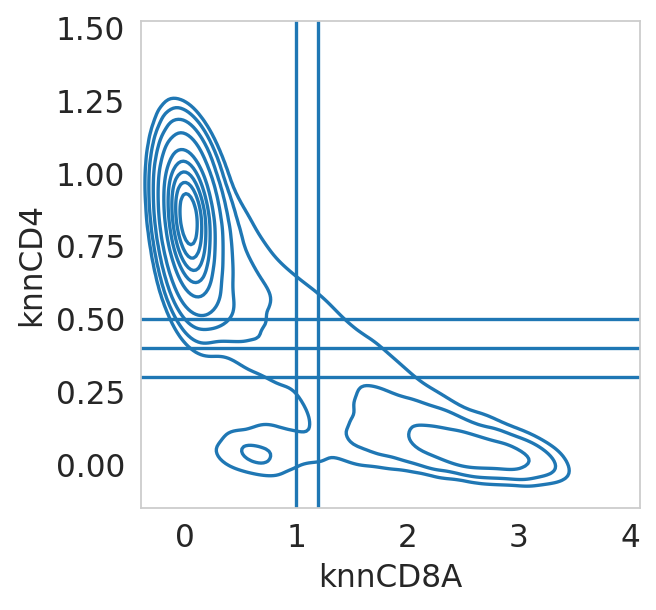

In [201]:
#sns.scatterplot(data = Tcell.obs,x = 'knnCD8A', y = 'knnCD4', )
sns.kdeplot(data = Tcell.obs,x = 'knnCD8A', y = 'knnCD4', )
plt.axvline(x = 1,)
plt.axvline(x = 1.2,)
plt.axhline(y = 0.5,)
plt.axhline(y = 0.4,)
plt.axhline(y = 0.3,)
plt.show()

In [202]:
CD8 = Tcell[(Tcell.obs['knnCD8A']>1.1)*(Tcell.obs['knnCD4']<=0.35)]
CD4 = Tcell[(Tcell.obs['knnCD8A']<1.1)*(Tcell.obs['knnCD4']>0.35)]

In [203]:
sc.pp.highly_variable_genes(mono, n_top_genes = 4000) 
sc.tl.pca(mono, n_comps=30)
sc.pp.neighbors(mono, n_neighbors=30)  
sc.tl.leiden(mono, key_added="leiden")
sc.tl.umap(mono)

In [206]:
cd16_mono = mono[mono.obs['leiden'].isin(['7','8'])]
dc = mono[mono.obs['leiden'].isin(['0'])]
cd14_mono = mono[~mono.obs['leiden'].isin(['0','7','8'])]

In [210]:
adata.obs['celltype'] = 'Others'
for df, name in zip([CD8, CD4, cd16_mono, cd14_mono, dc, B, NK], ['CD8+ T','CD4+ T','CD16+ monocyte','CD14+ monocyte','DC','B cell','NK cells']):
    adata.obs.loc[adata.obs.index.isin(df.obs.index),'celltype'] = name

## Filter V3 remove unclassified cells

In [227]:
adata_final = adata[adata.obs['celltype']!='Others'].copy()
adata_final.write_h5ad('rna_1128.h5ad')
adata_final.obs.to_csv('rna_obs.csv',sep = '\t',)

## Figure V4 - Harmonize within cell types 

In [306]:
sc.pp.highly_variable_genes(CD8, n_top_genes = 4000) 
CD8.var.loc[CD8.var.gene.isin(['XIST']),'highly_variable'] = False
sc.tl.pca(CD8, n_comps=30)

sc.pp.highly_variable_genes(CD4, n_top_genes = 4000) 
CD4.var.loc[CD4.var.gene.isin(['XIST']),'highly_variable'] = False
sc.tl.pca(CD4, n_comps=30)

In [307]:
import scanpy.external as sce
sce.pp.harmony_integrate(CD4, 'patient')
sce.pp.harmony_integrate(CD8, 'patient')

2024-11-28 13:51:37,794 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-28 13:51:46,566 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-28 13:51:46,750 - harmonypy - INFO - Iteration 1 of 10
2024-11-28 13:51:58,418 - harmonypy - INFO - Iteration 2 of 10
2024-11-28 13:52:09,765 - harmonypy - INFO - Iteration 3 of 10
2024-11-28 13:52:20,718 - harmonypy - INFO - Converged after 3 iterations
2024-11-28 13:52:20,733 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-28 13:52:23,441 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-28 13:52:23,466 - harmonypy - INFO - Iteration 1 of 10
2024-11-28 13:52:24,979 - harmonypy - INFO - Iteration 2 of 10
2024-11-28 13:52:26,510 - harmonypy - INFO - Iteration 3 of 10
2024-11-28 13:52:28,031 - harmonypy - INFO - Iteration 4 of 10
2024-11-28 13:52:29,562 - harmonypy - INFO - Converged after 4 iterations


In [309]:
sc.pp.neighbors(CD4, n_pcs=30, use_rep="X_pca_harmony")
sc.tl.umap(CD4)

sc.pp.neighbors(CD8, n_pcs=30, use_rep="X_pca_harmony")
sc.tl.umap(CD8)

In [310]:
CD4.obsm['X_umap_harmony'] = CD4.obsm['X_umap']
CD8.obsm['X_umap_harmony'] = CD8.obsm['X_umap']
CD8_new = CD8[CD8.obs['leiden']!='7'].copy()

In [326]:
sc.pp.highly_variable_genes(CD8_new, n_top_genes = 4000) 
CD8_new.var.loc[CD8_new.var.gene.isin(['XIST']),'highly_variable'] = False
sc.tl.pca(CD8_new, n_comps=30)
sce.pp.harmony_integrate(CD8_new, 'patient')
sc.pp.neighbors(CD8_new, n_pcs=30, use_rep="X_pca_harmony")
sc.tl.umap(CD8_new)
CD8_new.obsm['X_umap_harmony'] = CD8_new.obsm['X_umap']

2024-11-28 14:01:12,754 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-28 14:01:14,883 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-28 14:01:14,903 - harmonypy - INFO - Iteration 1 of 10
2024-11-28 14:01:16,150 - harmonypy - INFO - Iteration 2 of 10
2024-11-28 14:01:17,402 - harmonypy - INFO - Iteration 3 of 10
2024-11-28 14:01:18,640 - harmonypy - INFO - Iteration 4 of 10
2024-11-28 14:01:19,892 - harmonypy - INFO - Converged after 4 iterations


In [329]:
CD8_new.write_h5ad('CD8_1128.h5ad')
CD4.write_h5ad('CD4_1128.h5ad')

## Integrate TCR data 

In [ ]:
tcr_out = []
for i in os.listdir('.'):
    if 'TCR' in i :
        if '.sh' not in i:
            if 'ipynb' not in i :
                tcr_out.append(i)


input = pd.DataFrame({'dir':tcr_out})
input['sample'] = [i.replace('_VDJ','').replace('_B','').replace('_TCR','') for i in input['dir']]
input['project'] = [int(i.split('_')[-2]) for i in input['sample']]
input['ID']= [i.split('_')[1] for i in input['sample']]

In [ ]:
meta = pd.read_csv('project_14423_meta.csv',sep ='\t',header = None)
meta.columns = ['patient','timepoint','time','date','sample_id','barcode','date_processed','seq_sample','ID','trial']
meta['ID'] = meta['ID'].astype(str)
input_data = input[(input['ID'].isin(input['ID']))*(input['project'] == 14423)]

f_list = []

for a, i in zip(input_data['dir'].values, input_data['sample'].values):
    
    f = pd.read_csv(f'./{a}/outs/filtered_contig_annotations.csv',sep = ',')
    
    alpha = f[f['chain'] == 'TRA']
    alpha.index = alpha.barcode.copy()
    beta = f[f['chain'] == 'TRB']
    beta.index = beta.barcode.copy()
    alpha = alpha.drop(columns = ['barcode']).add_prefix('alpha_')
    beta = beta.drop(columns = ['barcode']).add_prefix('beta_')
    tcr = alpha.reset_index().merge(beta.reset_index(),left_on = 'barcode', right_on = 'barcode', how = 'outer')
    tcr['cohort'] = 14423
    tcr['ID'] = str(i.split('_')[1])
    tcr['sample'] = i    
    tcr['unique_ID'] = tcr['cohort'].astype(str)+"|"+tcr['ID'].astype(str)+"|"+tcr['barcode'].astype(str)
    
    f_list.append(tcr)
p14423 = pd.concat(f_list)

In [ ]:
meta = pd.read_csv('project_14450_meta.csv',sep ='\t',header = None)
meta.columns = ['patient','timepoint','time','date','sample_id','barcode','date_processed','seq_sample','ID','trial']
meta['ID'] = meta['ID'].astype(str)
input_data = input[(input['ID'].isin(input['ID']))*(input['project'] == 14450)]

f_list = []

for a, i in zip(input_data['dir'].values, input_data['sample'].values):
    
    f = pd.read_csv(f'./{a}/outs/filtered_contig_annotations.csv',sep = ',')
    
    alpha = f[f['chain'] == 'TRA']
    alpha.index = alpha.barcode.copy()
    beta = f[f['chain'] == 'TRB']
    beta.index = beta.barcode.copy()
    alpha = alpha.drop(columns = ['barcode']).add_prefix('alpha_')
    beta = beta.drop(columns = ['barcode']).add_prefix('beta_')
    tcr = alpha.reset_index().merge(beta.reset_index(),left_on = 'barcode', right_on = 'barcode', how = 'outer')
    tcr['cohort'] = 14450
    tcr['ID'] = str(i.split('_')[1])
    tcr['sample'] = i    
    tcr['unique_ID'] = tcr['cohort'].astype(str)+"|"+tcr['ID'].astype(str)+"|"+tcr['barcode'].astype(str)
    
    f_list.append(tcr)
p14450 = pd.concat(f_list)

In [ ]:
meta = pd.read_csv('project_14448_meta.csv',sep ='\t',header = None)
meta.columns = ['patient','timepoint','time','date','sample_id','barcode','date_processed','seq_sample','ID','trial']
meta['ID'] = meta['ID'].astype(str)
input_data = input[(input['ID'].isin(input['ID']))*(input['project'] == 14448)]

f_list = []

for a, i in zip(input_data['dir'].values, input_data['sample'].values):
    
    f = pd.read_csv(f'./{a}/outs/filtered_contig_annotations.csv',sep = ',')
    
    alpha = f[f['chain'] == 'TRA']
    alpha.index = alpha.barcode.copy()
    beta = f[f['chain'] == 'TRB']
    beta.index = beta.barcode.copy()
    alpha = alpha.drop(columns = ['barcode']).add_prefix('alpha_')
    beta = beta.drop(columns = ['barcode']).add_prefix('beta_')
    tcr = alpha.reset_index().merge(beta.reset_index(),left_on = 'barcode', right_on = 'barcode', how = 'outer')
    tcr['cohort'] = 14448
    tcr['ID'] = str(i.split('_')[1])
    tcr['sample'] = i    
    tcr['unique_ID'] = tcr['cohort'].astype(str)+"|"+tcr['ID'].astype(str)+"|"+tcr['barcode'].astype(str)
    
    f_list.append(tcr)
p14448 = pd.concat(f_list)

tcr_bind = pd.concat([ p14423,p14450, p14448])

In [ ]:
cd8 = sc.read_h5ad('CD8_1128.h5ad')
cd4 = sc.read_h5ad('CD4_1128.h5ad')

cd8.obs['cellstate'] = cd8.obs['leiden'].map({'0':'Effector','1':'Effector memory','3':'Effector memory','2':'Stem-like','4':'Stem-like'})
cd4.obs['cellstate'] = cd4.obs['leiden'].map({'7':'Effector','6':'T-reg',})
cd4.obs.loc[cd4.obs['cellstate'].isna(),'cellstate'] = 'Stem-like'

cd4.obs['response'] = 'Non-responder'
cd4.obs.loc[cd4.obs['patient'].isin(['10606','11414']),'response'] = 'Responder'

cd8.obs['response'] = 'Non-responder'
cd8.obs.loc[cd8.obs['patient'].isin(['10606','11414']),'response'] = 'Responder'



In [ ]:
### Final CD8, CD4 anndata

cd8.write_h5ad('cd8_human_final.h5ad')
cd4.write_h5ad('cd4_human_final.h5ad')

In [ ]:
cd8_df = cd8.obs.copy()
cd4_df = cd4.obs.copy()

cd8_df['unique_ID'] = cd8_df['cohort'].astype(str)+"|"+cd8_df['10X_ID'].astype(str)+"|"+cd8_df['ident'].astype(str)
cd4_df['unique_ID'] = cd4_df['cohort'].astype(str)+"|"+cd4_df['10X_ID'].astype(str)+"|"+cd4_df['ident'].astype(str)

cd4_df = cd4_df.reset_index()
cd8_df = cd8_df.reset_index()

cd8_tcr = tcr_bind[tcr_bind['unique_ID'].isin(cd8_df['unique_ID'])]
cd4_tcr = tcr_bind[tcr_bind['unique_ID'].isin(cd4_df['unique_ID'])]

cd8_tcr['clone_pair'] =  cd8_tcr['alpha_cdr3_nt']+  cd8_tcr['beta_cdr3_nt']
cd4_tcr['clone_pair'] =  cd4_tcr['alpha_cdr3_nt']+  cd4_tcr['beta_cdr3_nt']

cd8_tcr = cd8_tcr.dropna(subset=['beta_cdr3'])
cd4_tcr = cd4_tcr.dropna(subset=['beta_cdr3'])

cd8_merge = cd8_df.merge(cd8_tcr, left_on = 'unique_ID', right_on ='unique_ID')
cd4_merge = cd4_df.merge(cd4_tcr, left_on = 'unique_ID', right_on ='unique_ID')

cd8_merge_clean = cd8_merge[(~cd8_merge['timepoint'].isin(['Day 28 F/U',])) ]
cd4_merge_clean = cd4_merge[(~cd4_merge['timepoint'].isin(['Day 28 F/U',])) ]

cd8_merge_clean['patient'] = cd8_merge_clean['patient'].astype(str)
cd4_merge_clean['patient'] = cd4_merge_clean['patient'].astype(str)

cd8_merge_clean['timepoint'] = cd8_merge_clean['timepoint'].astype(str)
cd4_merge_clean['timepoint'] = cd4_merge_clean['timepoint'].astype(str)

cd8_merge_clean['leiden'] = cd8_merge_clean['leiden'].astype(str)

In [ ]:
## final integrated CD4, CD8 TCR csv file 

cd8_merge_clean.to_csv('cd8_merge_clean.csv',sep ='\t')
cd4_merge_clean.to_csv('cd4_merge_clean.csv',sep ='\t')